# Understanding Squidpy Co-occurance

In [21]:
import squidpy as sq
import numpy as np
import pandas as pd
import numba.types as nt

import matplotlib.pyplot as plt

# pip install git+https://github.com/h2oai/datatable.git
import datatable

import os
import csv

In [22]:
meta = datatable.fread("exported_data/sim.csv")
meta = meta.to_pandas().set_index('C0')
meta.head()

,x,y,celltypes
C0,,,
cell1,531.017326,256.530309,A
cell2,744.247799,255.383047,D
cell3,1145.706727,1555.464671,D
cell4,1816.415580,840.300727,D
cell5,403.363862,1431.803866,A


In [23]:
# just some random data for gene expression because I'm just interested in getting the coordinates and labels in there
from anndata import AnnData
from numpy.random import default_rng
rng = default_rng(42)

counts = rng.integers(0, 15, size=(meta.shape[0], 50))
counts.shape

(8000, 50)

In [24]:
adata = AnnData(counts, obsm={"spatial": np.array(meta[["x", "y"]], dtype=float)})


In [25]:
adata.obs = meta
adata.obs['celltypes'] = adata.obs['celltypes'].astype('category')

# Co-occurence

## Aux functions

In [7]:
"""Functions for point patterns spatial statistics."""

from __future__ import annotations

from itertools import chain
from typing import (
    TYPE_CHECKING,
    Any,
    Dict,
    Iterable,
    Literal,  # < 3.8
    Sequence,
    Union,  # noqa: F401
)

import numba.types as nt
import numpy as np
import pandas as pd
from anndata import AnnData
from numba import njit
from numpy.random import default_rng
from scanpy import logging as logg
from scanpy.get import _get_obs_rep
from scanpy.metrics._gearys_c import _gearys_c
from scanpy.metrics._morans_i import _morans_i
from scipy import stats
from scipy.sparse import spmatrix
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
#from spatialdata import SpatialData
from statsmodels.stats.multitest import multipletests

from squidpy._constants._constants import SpatialAutocorr
from squidpy._constants._pkg_constants import Key
from squidpy._docs import d, inject_docs
from squidpy._utils import NDArrayA, Signal, SigQueue, _get_n_cores, parallelize
from squidpy.gr._utils import (
    _assert_categorical_obs,
    _assert_connectivity_key,
    _assert_non_empty_sequence,
    _assert_positive,
    _assert_spatial_basis,
    _save_data,
)

__all__ = ["spatial_autocorr", "co_occurrence"]


it = nt.int32
ft = nt.float32
tt = nt.UniTuple
ip = np.int32
fp = np.float32

In [8]:
@njit(
    ft[:, :, :](tt(it[:], 2), ft[:, :], it[:], ft[:]),
    parallel=False,
    fastmath=True,
)
def _occur_count(
    clust: tuple[NDArrayA, NDArrayA],
    pw_dist: NDArrayA,
    labs_unique: NDArrayA,
    interval: NDArrayA,
) -> NDArrayA:
    num = labs_unique.shape[0]
    out = np.zeros((num, num, interval.shape[0] - 1), dtype=ft)

    for idx in range(interval.shape[0] - 1):
        co_occur = np.zeros((num, num), dtype=ft)
        probs_con = np.zeros((num, num), dtype=ft)

        thres_min = interval[idx]
        thres_max = interval[idx + 1]
        clust_x, clust_y = clust

        idx_x, idx_y = np.nonzero((pw_dist <= thres_max) & (pw_dist > thres_min))
        x = clust_x[idx_x]
        y = clust_y[idx_y]
        for i, j in zip(x, y):
            co_occur[i, j] += 1

        probs_matrix = co_occur / np.sum(co_occur)
        probs = np.sum(probs_matrix, axis=1)

        for c in labs_unique:
            probs_conditional = co_occur[c] / np.sum(co_occur[c])
            probs_con[c, :] = probs_conditional / probs

        out[:, :, idx] = probs_con

    return out

In [9]:
def _co_occurrence_helper(
    idx_splits: Iterable[tuple[int, int]],
    spatial_splits: Sequence[NDArrayA],
    labs_splits: Sequence[NDArrayA],
    labs_unique: NDArrayA,
    interval: NDArrayA,
    queue: SigQueue | None = None,
) -> pd.DataFrame:
    out_lst = []
    for t in idx_splits:
        idx_x, idx_y = t
        labs_x = labs_splits[idx_x]
        labs_y = labs_splits[idx_y]
        dist = pairwise_distances(spatial_splits[idx_x], spatial_splits[idx_y])

        out = _occur_count((labs_x, labs_y), dist, labs_unique, interval)
        out_lst.append(out)

        if queue is not None:
            queue.put(Signal.UPDATE)

    if queue is not None:
        queue.put(Signal.FINISH)

    return out_lst

In [10]:
def _find_min_max(spatial: NDArrayA) -> tuple[float, float]:
    coord_sum = np.sum(spatial, axis=1)
    min_idx, min_idx2 = np.argpartition(coord_sum, 2)[:2]
    max_idx = np.argmax(coord_sum)
    # fmt: off
    thres_max = pairwise_distances(spatial[min_idx, :].reshape(1, -1), spatial[max_idx, :].reshape(1, -1))[0, 0] / 2.0
    thres_min = pairwise_distances(spatial[min_idx, :].reshape(1, -1), spatial[min_idx2, :].reshape(1, -1))[0, 0]
    # fmt: on

    return thres_min.astype(fp), thres_max.astype(fp)

## Main function

In [28]:
def co_occurrence(
    adata: AnnData | SpatialData,
    cluster_key: str,
    spatial_key: str = Key.obsm.spatial,
    interval: int | NDArrayA = 50,
    copy: bool = False,
    n_splits: int | None = None,
    n_jobs: int | None = None,
    backend: str = "loky",
    show_progress_bar: bool = True,
) -> tuple[NDArrayA, NDArrayA] | None:
    
    # if isinstance(adata, SpatialData):
    #     adata = adata.table
    _assert_categorical_obs(adata, key=cluster_key)
    _assert_spatial_basis(adata, key=spatial_key)

    spatial = adata.obsm[spatial_key].astype(fp)
    original_clust = adata.obs[cluster_key]

    # annotate cluster idx
    clust_map = {v: i for i, v in enumerate(original_clust.cat.categories.values)}
    labs = np.array([clust_map[c] for c in original_clust], dtype=ip)
    labs_unique = np.array(list(clust_map.values()), dtype=ip)

    # create intervals thresholds
    if isinstance(interval, int):
        thresh_min, thresh_max = _find_min_max(spatial)
        interval = np.linspace(thresh_min, thresh_max, num=interval, dtype=fp)
    else:
        interval = np.array(sorted(interval), dtype=fp, copy=True)
    if len(interval) <= 1:
        raise ValueError(f"Expected interval to be of length `>= 2`, found `{len(interval)}`.")

    n_obs = spatial.shape[0]
    if n_splits is None:
        size_arr = (n_obs**2 * spatial.itemsize) / 1024 / 1024  # calc expected mem usage
        if size_arr > 2000:
            n_splits = 1
            while 2048 < (n_obs / n_splits):
                n_splits += 1
            logg.warning(
                f"`n_splits` was automatically set to `{n_splits}` to "
                f"prevent `{n_obs}x{n_obs}` distance matrix from being created"
            )
        else:
            n_splits = 1
    n_splits = max(min(n_splits, n_obs), 1)

    # split array and labels
    spatial_splits = tuple(s for s in np.array_split(spatial, n_splits, axis=0) if len(s))  # type: ignore[arg-type]
    labs_splits = tuple(s for s in np.array_split(labs, n_splits, axis=0) if len(s))  # type: ignore[arg-type]
    # create idx array including unique combinations and self-comparison
    x, y = np.triu_indices_from(np.empty((n_splits, n_splits)))  # type: ignore[arg-type]
    idx_splits = list(zip(x, y))

    n_jobs = _get_n_cores(n_jobs)
    start = logg.info(
        f"Calculating co-occurrence probabilities for `{len(interval)}` intervals "
        f"`{len(idx_splits)}` split combinations using `{n_jobs}` core(s)"
    )

    out_lst = parallelize(
        _co_occurrence_helper,
        collection=idx_splits,
        extractor=chain.from_iterable,
        n_jobs=n_jobs,
        backend=backend,
        show_progress_bar=show_progress_bar,
    )(
        spatial_splits=spatial_splits,
        labs_splits=labs_splits,
        labs_unique=labs_unique,
        interval=interval,
    )
    out = list(out_lst)[0] if len(idx_splits) == 1 else sum(list(out_lst)) / len(idx_splits)

    if copy:
        logg.info("Finish", time=start)
        return out, interval

    _save_data(
        adata, attr="uns", key=Key.uns.co_occurrence(cluster_key), data={"occ": out, "interval": interval}, time=start
    )

In [29]:
co_occurrence(adata, cluster_key = "celltypes")

/Users/rafaeldossantospeixoto/anaconda3/envs/squidpy/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1/1 [00:10<00:00, 10.09s/]


## Function call

### Parameters

In [31]:
# sq.gr.co_occurrence(adata, cluster_key = "celltypes")

# adata = adata
cluster_key = "celltypes"
spatial_key = "spatial"
interval = 50
copy = False
n_splits = None
n_jobs = None
backend = "loky"
show_progress_bar = True


### Function

#### Main

In [32]:
# if isinstance(adata, SpatialData):
#     adata = adata.table
_assert_categorical_obs(adata, key=cluster_key)
_assert_spatial_basis(adata, key=spatial_key)

spatial = adata.obsm[spatial_key].astype(fp)
original_clust = adata.obs[cluster_key]

In [35]:
# annotate cluster idx
## just convert into numbers and find unique
clust_map = {v: i for i, v in enumerate(original_clust.cat.categories.values)}
labs = np.array([clust_map[c] for c in original_clust], dtype=ip)
labs_unique = np.array(list(clust_map.values()), dtype=ip)

In [43]:
# create intervals thresholds
if isinstance(interval, int):
    thresh_min, thresh_max = _find_min_max(spatial)
    interval = np.linspace(thresh_min, thresh_max, num=interval, dtype=fp)
else:
    interval = np.array(sorted(interval), dtype=fp, copy=True)
if len(interval) <= 1:
    raise ValueError(f"Expected interval to be of length `>= 2`, found `{len(interval)}`.")

In [46]:
interval

array([  25.094666,   53.210125,   81.325584,  109.44105 ,  137.5565  ,
        165.67197 ,  193.78743 ,  221.90288 ,  250.01834 ,  278.1338  ,
        306.24927 ,  334.36472 ,  362.4802  ,  390.59564 ,  418.7111  ,
        446.82657 ,  474.94202 ,  503.0575  ,  531.1729  ,  559.2884  ,
        587.4039  ,  615.51935 ,  643.63477 ,  671.75024 ,  699.8657  ,
        727.98114 ,  756.0966  ,  784.2121  ,  812.3275  ,  840.443   ,
        868.5585  ,  896.67395 ,  924.78937 ,  952.90485 ,  981.0203  ,
       1009.13574 , 1037.2512  , 1065.3667  , 1093.4822  , 1121.5977  ,
       1149.713   , 1177.8285  , 1205.944   , 1234.0594  , 1262.1749  ,
       1290.2904  , 1318.4058  , 1346.5212  , 1374.6367  , 1402.7522  ],
      dtype=float32)

In [48]:
## I believe this is just to see if memory won't overflow
n_obs = spatial.shape[0]
if n_splits is None:
    size_arr = (n_obs**2 * spatial.itemsize) / 1024 / 1024  # calc expected mem usage
    if size_arr > 2000:
        n_splits = 1
        while 2048 < (n_obs / n_splits):
            n_splits += 1
        logg.warning(
            f"`n_splits` was automatically set to `{n_splits}` to "
            f"prevent `{n_obs}x{n_obs}` distance matrix from being created"
        )
    else:
        n_splits = 1
n_splits = max(min(n_splits, n_obs), 1)

In [49]:
n_splits

1

In [84]:
## did not change anything, just put into tuples, but since n_splits = 1, it is a tuple
## of only one value
# split array and labels
spatial_splits = tuple(s for s in np.array_split(spatial, n_splits, axis=0) if len(s))  # type: ignore[arg-type]
labs_splits = tuple(s for s in np.array_split(labs, n_splits, axis=0) if len(s))  # type: ignore[arg-type]
# create idx array including unique combinations and self-comparison
x, y = np.triu_indices_from(np.empty((n_splits, n_splits)))  # type: ignore[arg-type]
idx_splits = list(zip(x, y))

In [85]:
n_jobs = _get_n_cores(n_jobs)
start = logg.info(
    f"Calculating co-occurrence probabilities for `{len(interval)}` intervals "
    f"`{len(idx_splits)}` split combinations using `{n_jobs}` core(s)"
)

In [57]:
## Didn't run this part because it is parallelization of what I need to understand
# out_lst = parallelize(
#     _co_occurrence_helper,
#     collection=idx_splits,
#     extractor=chain.from_iterable,
#     n_jobs=n_jobs,
#     backend=backend,
#     show_progress_bar=show_progress_bar,
# )(
#     spatial_splits=spatial_splits,
#     labs_splits=labs_splits,
#     labs_unique=labs_unique,
#     interval=interval,
# )
# out = list(out_lst)[0] if len(idx_splits) == 1 else sum(list(out_lst)) / len(idx_splits)

#### Helper

In [91]:
idx_splits

[(0, 0)]

In [92]:
out_lst = []

## since there is only one split, I removed the loop
# for t in idx_splits:
t = idx_splits[0]
idx_x, idx_y = t
labs_x = labs_splits[idx_x]
labs_y = labs_splits[idx_y]
## calculate the distance between each cell
dist = pairwise_distances(spatial_splits[idx_x], spatial_splits[idx_y])

In [96]:
dist[1:5,1:5]

array([[   0.     , 1360.6549 , 1221.3405 , 1224.8134 ],
       [1360.6549 ,    0.     ,  980.46405,  752.5723 ],
       [1221.3405 ,  980.46405,    0.     , 1531.8586 ],
       [1224.8134 ,  752.5723 , 1531.8586 ,    0.     ]], dtype=float32)

In [124]:
## is symmetric
np.array_equal(dist, dist.T)

True

#### Count

In [98]:
clust = (labs_x, labs_y)
pw_dist = dist
labs_unique = labs_unique
interval = interval

In [103]:
## labels are the same, not sure why x and y
all(clust[0] == clust[1])

True

In [115]:
num = labs_unique.shape[0]
## fixed ft to np.float32, same error in other pars, update variable
ft = np.float32
out = np.zeros((num, num, interval.shape[0] - 1), dtype=ft)

In [152]:
## removed loop to test
# for idx in range(interval.shape[0] - 1):
## iterate over the intervals and calculate probs for each pair
idx = range(interval.shape[0] - 1)[25]
co_occur = np.zeros((num, num), dtype=ft)
probs_con = np.zeros((num, num), dtype=ft)

In [153]:
thres_min = interval[idx]
thres_max = interval[idx + 1]
clust_x, clust_y = clust

In [154]:
## indeed define a min and max threshold
thres_min, thres_max

(727.98114, 756.0966)

In [155]:
np.nonzero((pw_dist <= thres_max) & (pw_dist > thres_min))[0].shape

(1188618,)

In [156]:
## symmetric matrix, for each cell, the condition will be satisfied twice
idx_x, idx_y = np.nonzero((pw_dist <= thres_max) & (pw_dist > thres_min))
## get the cluster for the x axis (one cell) and the y axis (other cell)
x = clust_x[idx_x]
y = clust_y[idx_y]
## the co_occur matrix is n_cts x n_cts, so if the distance of a cell from type A
## to another from type B is within the region, we will add 1 to the co_occur matrix
## at row = ct A and col = ct B. Since the matrix is symmetric, in this process, we 
## will find the same pair as B to A, and therefore add 1 to row ct B and col ct A
for i, j in zip(x, y):
    co_occur[i, j] += 1

In [157]:
## also symmetric
co_occur

array([[ 50040.,   3764.,   2883., 225996.],
       [  3764.,      0.,      0.,  13889.],
       [  2883.,      0.,      0.,  12211.],
       [225996.,  13889.,  12211., 621092.]], dtype=float32)

In [159]:
## same as the number of elements that satisfied the distance condition: 1188618
np.sum(co_occur)

1188618.0

In [160]:
## divide the number of counts that satisfy the condition for each pair by the total
probs_matrix = co_occur / np.sum(co_occur)
probs = np.sum(probs_matrix, axis=1)

In [164]:
## symmetric
## of all the cells that are within a distance d from each other, 
## 0.04 will be from ct A to A, 0.003 from A to B...
probs_matrix

array([[0.04209931, 0.0031667 , 0.00242551, 0.19013342],
       [0.0031667 , 0.        , 0.        , 0.011685  ],
       [0.00242551, 0.        , 0.        , 0.01027327],
       [0.19013342, 0.011685  , 0.01027327, 0.5225329 ]], dtype=float32)

In [165]:
## off all cells pairs within distance, .23 will be with type A, .01 with type B
probs

array([0.23782495, 0.0148517 , 0.01269878, 0.73462456], dtype=float32)

In [179]:
# for c in labs_unique:
c = 0
probs_conditional = co_occur[c] / np.sum(co_occur[c])
probs_con[c, :] = probs_conditional / probs

In [190]:
co_occur[c] / np.sum(co_occur)

array([0.04209931, 0.0031667 , 0.00242551, 0.19013342], dtype=float32)

In [175]:
for c in labs_unique:
    ## select one row of the matrix, as the reference
    ## divide by the sum of counts of that row to
    ## calculate the proportion of of other cell types 
    ## within the distance of the ref ct
    probs_conditional = co_occur[c] / np.sum(co_occur[c])
    ## divide by the global proportion of having a ct within the pairs
    ## row as ref
    probs_con[c, :] = probs_conditional / probs

## save in the output file
out[:, :, idx] = probs_con

In [177]:
## still symmetric, but it doesnt matter
out[:, :, 25]

array([[0.74432087, 0.8965484 , 0.8031246 , 1.0882674 ],
       [0.8965483 , 0.        , 0.        , 1.0709939 ],
       [0.80312455, 0.        , 0.        , 1.1012386 ],
       [1.0882673 , 1.0709939 , 1.1012387 , 0.9682393 ]], dtype=float32)

In [ ]:
## what are the distances then?

#### Continue Main

In [65]:
out = list(out_lst)[0] if len(idx_splits) == 1 else sum(list(out_lst)) / len(idx_splits)


In [66]:
_save_data(
        adata, attr="uns", key=Key.uns.co_occurrence(cluster_key), data={"occ": out, "interval": interval}, time=start
    )

# Continue analysis

In [67]:
adata

AnnData object with n_obs × n_vars = 8000 × 50
    obs: 'x', 'y', 'celltypes'
    uns: 'celltypes_co_occurrence'
    obsm: 'spatial'

In [68]:
## get the co-occurance values
occ = adata.uns["celltypes_co_occurrence"]["occ"]
occ.shape

(4, 4, 49)

In [69]:
## get the intervals
intervals = adata.uns["celltypes_co_occurrence"]["interval"]
intervals.shape

(50,)

In [187]:
intervals

array([  25.094666,   53.210125,   81.325584,  109.44105 ,  137.5565  ,
        165.67197 ,  193.78743 ,  221.90288 ,  250.01834 ,  278.1338  ,
        306.24927 ,  334.36472 ,  362.4802  ,  390.59564 ,  418.7111  ,
        446.82657 ,  474.94202 ,  503.0575  ,  531.1729  ,  559.2884  ,
        587.4039  ,  615.51935 ,  643.63477 ,  671.75024 ,  699.8657  ,
        727.98114 ,  756.0966  ,  784.2121  ,  812.3275  ,  840.443   ,
        868.5585  ,  896.67395 ,  924.78937 ,  952.90485 ,  981.0203  ,
       1009.13574 , 1037.2512  , 1065.3667  , 1093.4822  , 1121.5977  ,
       1149.713   , 1177.8285  , 1205.944   , 1234.0594  , 1262.1749  ,
       1290.2904  , 1318.4058  , 1346.5212  , 1374.6367  , 1402.7522  ],
      dtype=float32)

In [186]:
intervals[1:] - intervals[:-1]

array([28.11546 , 28.11546 , 28.115463, 28.115456, 28.115463, 28.115463,
       28.115448, 28.115463, 28.115448, 28.115479, 28.115448, 28.115479,
       28.115448, 28.115448, 28.115479, 28.115448, 28.115479, 28.115417,
       28.115479, 28.115479, 28.115479, 28.115417, 28.115479, 28.115479,
       28.115417, 28.115479, 28.115479, 28.115417, 28.115479, 28.115479,
       28.115479, 28.115417, 28.115479, 28.115479, 28.115417, 28.115479,
       28.115479, 28.115479, 28.115479, 28.115356, 28.115479, 28.115479,
       28.115479, 28.115479, 28.115479, 28.115356, 28.115479, 28.115479,
       28.115479], dtype=float32)

ERROR: Unable to fetch palette, reason: 'celltypes_colors'. Using `None`.
ERROR: Unable to fetch palette, reason: 'celltypes_colors'. Using `None`.
ERROR: Unable to fetch palette, reason: 'celltypes_colors'. Using `None`.
ERROR: Unable to fetch palette, reason: 'celltypes_colors'. Using `None`.


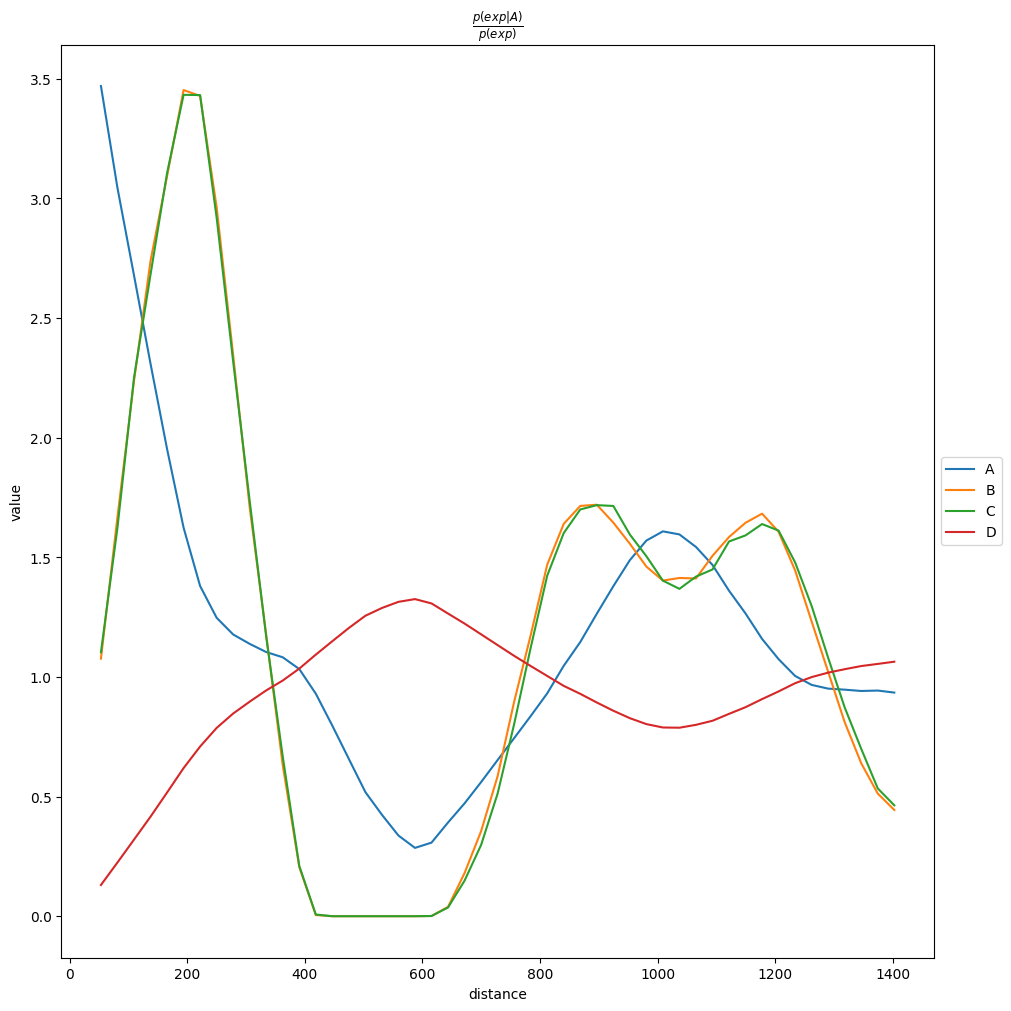

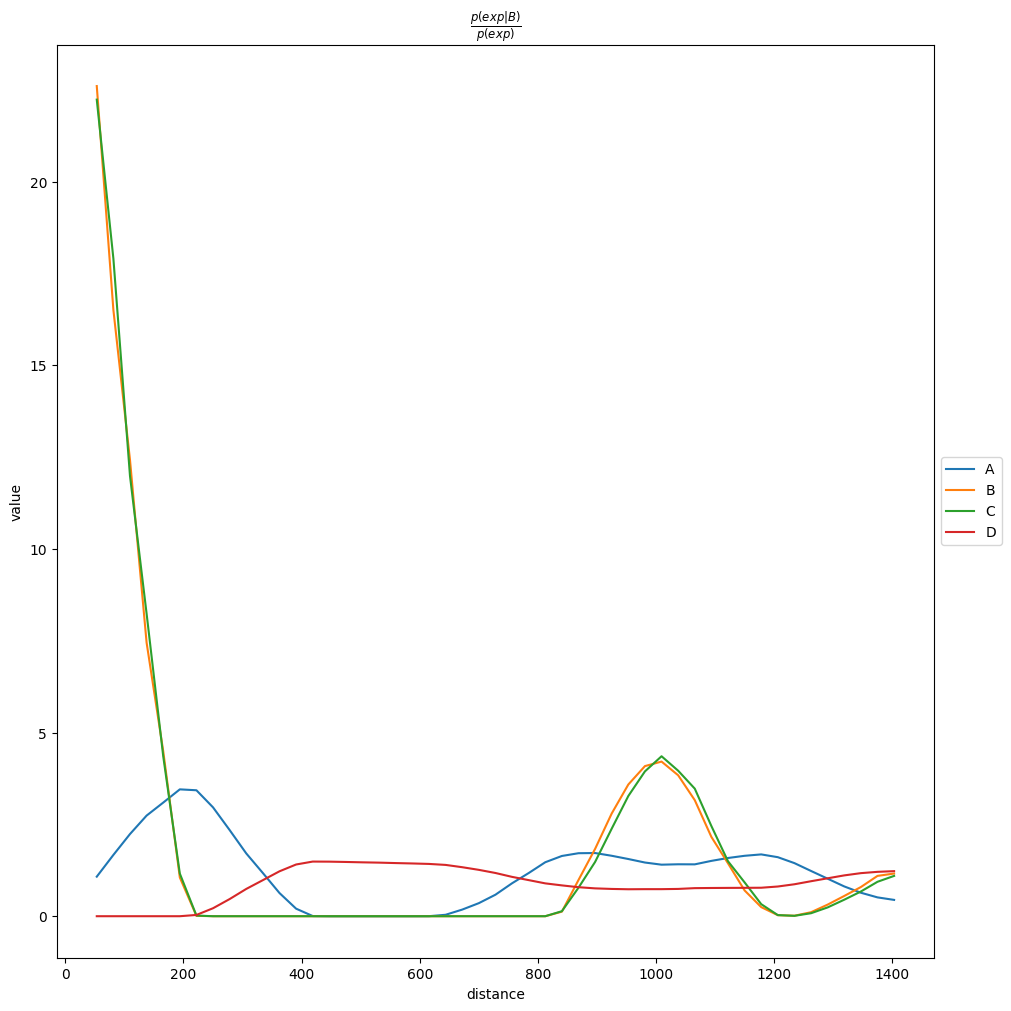

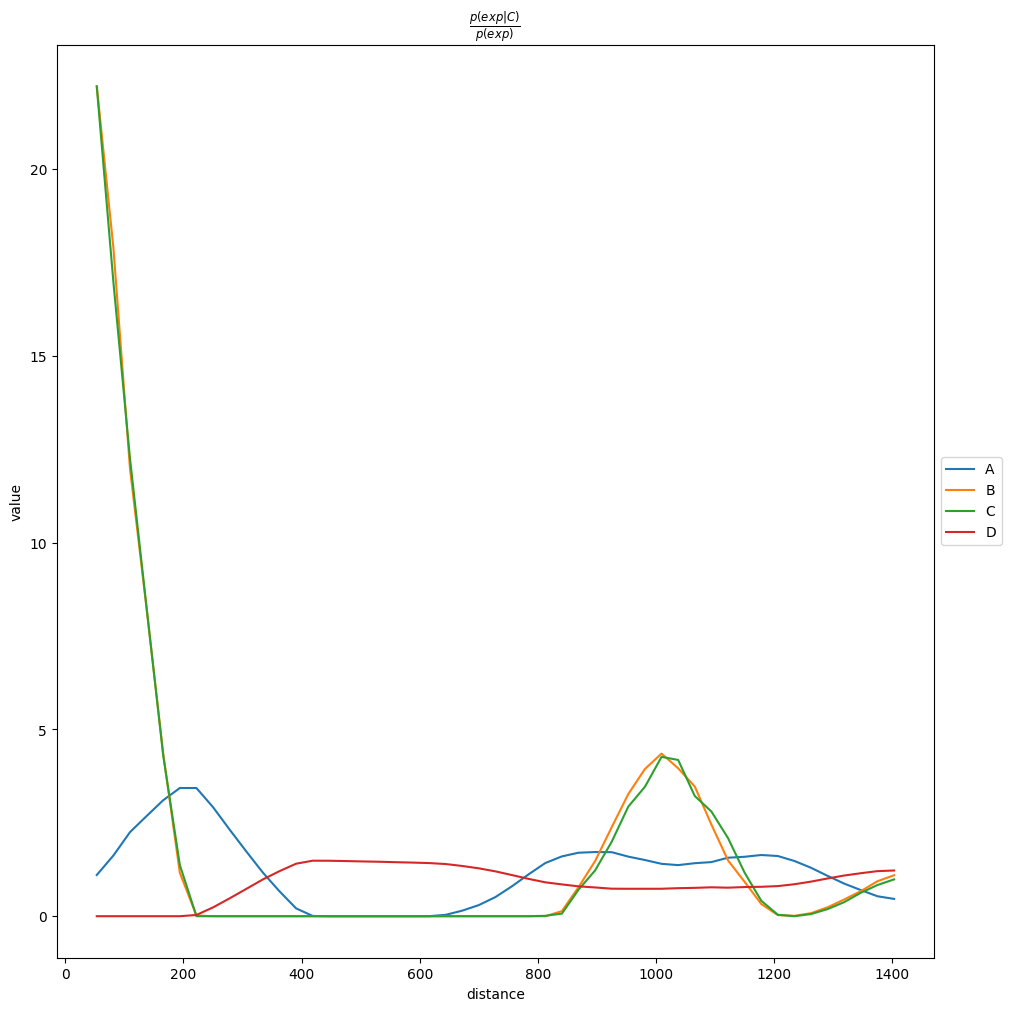

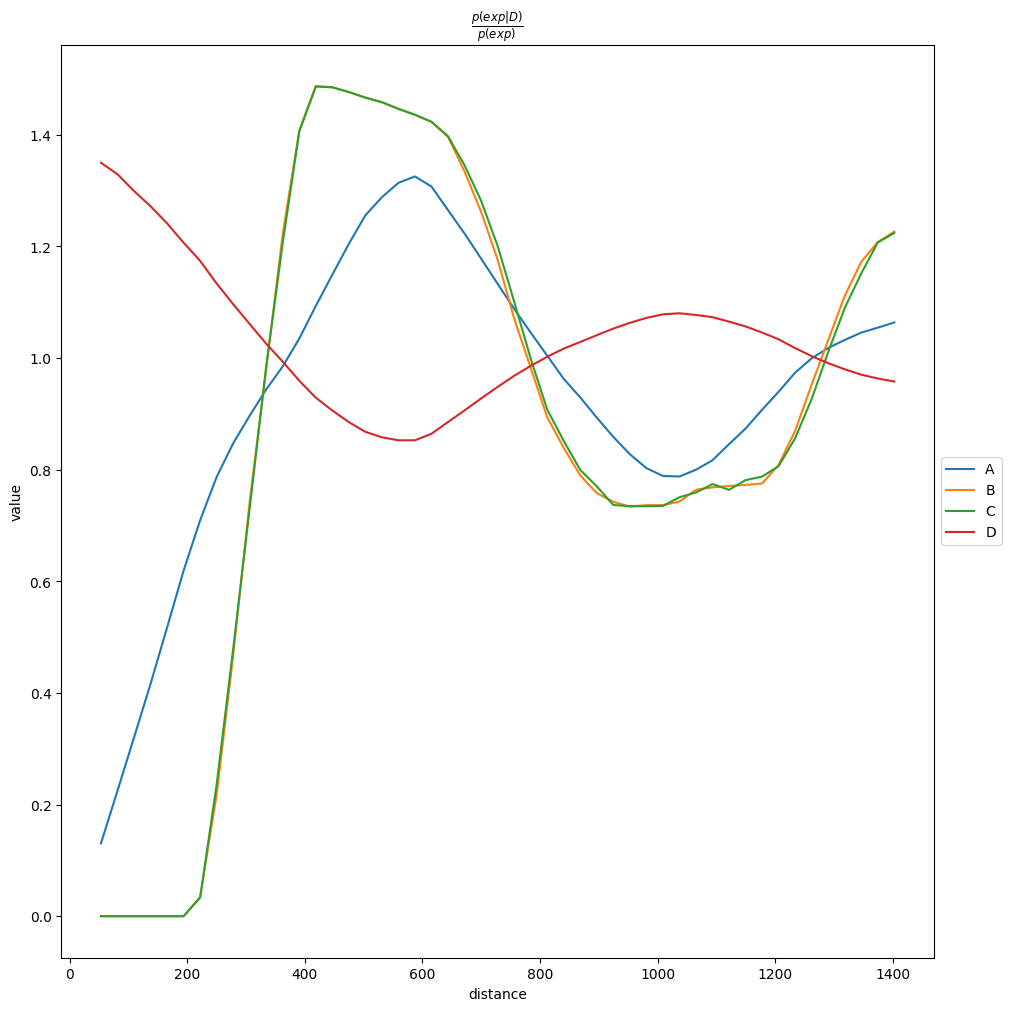

In [70]:
for ct in np.unique(adata.obs["celltypes"]):
    sq.pl.co_occurrence(adata, cluster_key="celltypes", clusters=ct,
                        save="simulation_co_occurance.{}.pdf".format(ct),
                        figsize=(10,10))